In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
raw_dataset = pd.read_csv("~/data/glac/TTT.csv")
# raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/TTT.csv")

dataset = raw_dataset.copy()

#examine missing data
dataset.head()

2.6.0


/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,GlaThiDa_ID,POLITICAL_UNIT,GLACIER_NAME,SURVEY_DATE,PROFILE_ID,POINT_ID,POINT_LAT,POINT_LON,ELEVATION,THICKNESS,THICKNESS_UNCERTAINTY,DATA_FLAG,REMARKS
0,33,US,EASTON,19929999.0,NaN,1.0,48.767380,-121.819644,2962.0,0,NaN,NaN,NaN
1,33,US,EASTON,19929999.0,NaN,2.0,48.764904,-121.821909,2813.0,29,NaN,NaN,NaN
2,33,US,EASTON,19929999.0,NaN,3.0,48.761662,-121.825264,2598.0,41,NaN,NaN,NaN
3,33,US,EASTON,19929999.0,NaN,4.0,48.757063,-121.829107,2383.0,71,NaN,NaN,NaN
4,33,US,EASTON,19929999.0,NaN,5.0,48.753715,-121.832006,2284.0,82,NaN,NaN,NaN


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("PROFILE_ID", axis=1)
dataset = dataset.drop("POINT_ID", axis=1)
dataset = dataset.drop("THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("REMARKS", axis=1)

#sum up rows with empty cells
dataset = dataset.dropna()
dataset.isna().sum()

POINT_LAT    0
POINT_LON    0
ELEVATION    0
THICKNESS    0
dtype: int64

In [3]:
dataset

,POINT_LAT,POINT_LON,ELEVATION,THICKNESS
0,48.767380,-121.819644,2962.0,0
1,48.764904,-121.821909,2813.0,29
2,48.761662,-121.825264,2598.0,41
3,48.757063,-121.829107,2383.0,71
4,48.753715,-121.832006,2284.0,82
...,...,...,...,...
3854274,47.092690,12.380504,3329.0,36
3854275,47.093780,12.379642,3353.0,26
3854276,47.094839,12.378200,3381.0,39
3854277,47.094829,12.378174,3381.0,39


In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

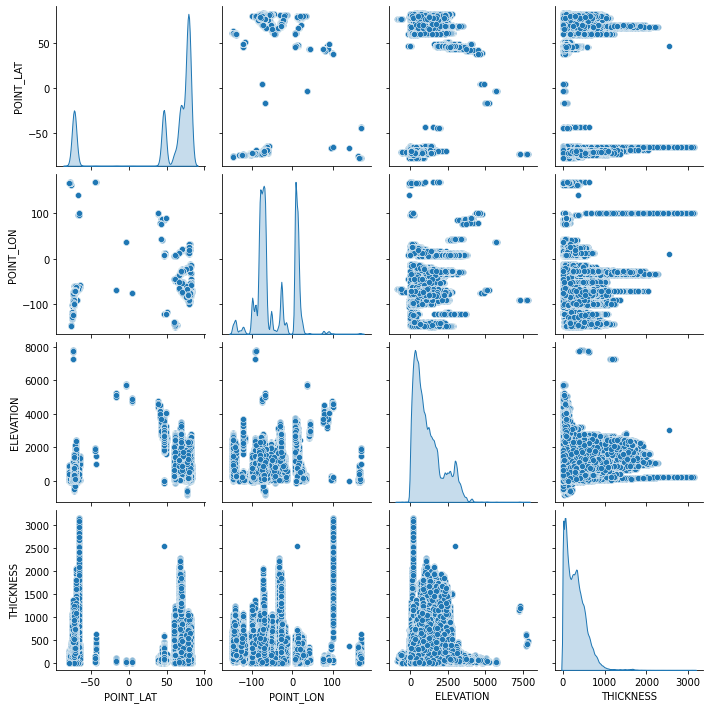

In [5]:
sns.pairplot(train_dataset[["POINT_LAT", "POINT_LON", "ELEVATION", "THICKNESS"]], diag_kind='kde')

In [6]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("THICKNESS")
test_labels = test_features.pop("THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
POINT_LAT,47.477816,53.238428
POINT_LON,-46.458083,45.484560
ELEVATION,1175.033891,937.446613


In [7]:
#establish normalization layers
normalizer = {}
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    normalizer[variable_name] = preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

In [8]:
def build_linear_model(normalizer):
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.1),
        loss="mean_absolute_error")
    
    return model

def plot_single_model_variable(x, y,feature_name):
    plt.scatter(train_features[feature_name], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature_name)
    plt.ylabel("Avg Thickness (m)")
#     plt.xlim((0,20))
    plt.legend()
      
def plot_loss(history):
#     plt.subplots(figsize=(10,5))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #   plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    

In [9]:
test_results = {}
linear_model = {}
linear_history = {}
linear_results = {}

In [10]:
%%time
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    linear_model[variable_name] = build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=10,
                                        verbose=0,
                                        validation_split = 0.2)
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

linear_results

CPU times: user 15min 19s, sys: 1min 33s, total: 16min 52s
Wall time: 10min 50s


{'POINT_LAT': 184.5479736328125,
 'POINT_LON': 166.419677734375,
 'ELEVATION': 174.94888305664062}

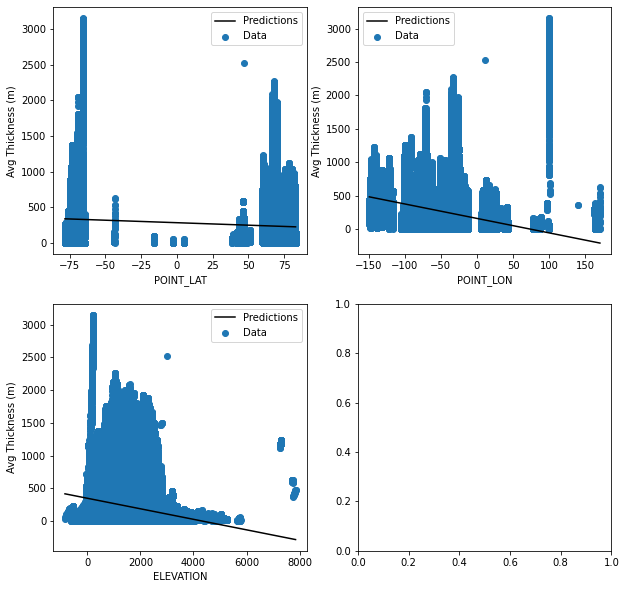

In [11]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = linear_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

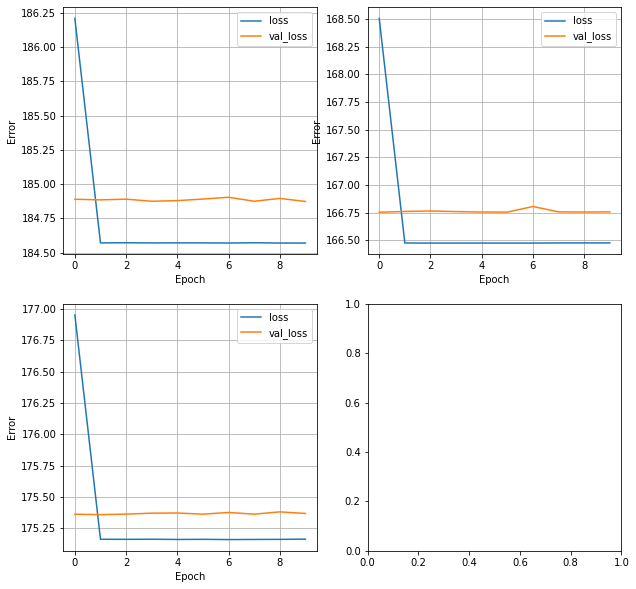

In [12]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(linear_history[variable_name])

In [13]:
%%time
linear_model = build_linear_model(normalizer['ALL'])

history = linear_model.fit(
train_features, train_labels,        
   epochs=10,
   verbose=0,
   validation_split = 0.2)

test_results["MULTI"] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

CPU times: user 4min 52s, sys: 28.1 s, total: 5min 21s
Wall time: 3min 28s


{'MULTI': 162.404296875}

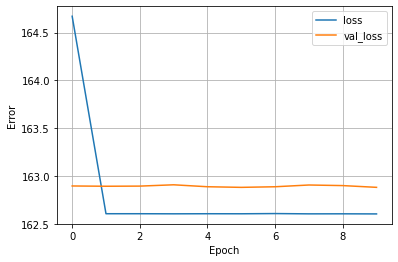

In [14]:
plot_loss(history)

In [15]:
def build_dnn_model(norm):
    model = keras.Sequential([
              norm,
              layers.Dense(64, activation='relu'),
              layers.Dense(64, activation='relu'),
              layers.Dense(1) ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))
    
    return model

def dnn_test_results(feature_name):
    dnn_test_results[feature_name] = dnn_model.evaluate(
        test_features[feature_name],
        test_labels, verbose=0)

In [16]:
test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [25]:
%%time
variable_list = ("POINT_LAT", "POINT_LON", "ELEVATION")
for variable_name in variable_list:

    dnn_model[variable_name] = build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=10,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

dnn_results

CPU times: user 5h 18min 18s, sys: 1h 10min 46s, total: 6h 29min 5s
Wall time: 26min 29s


{'POINT_LAT': 154.7535400390625,
 'POINT_LON': 144.3267364501953,
 'ELEVATION': 162.00759887695312}

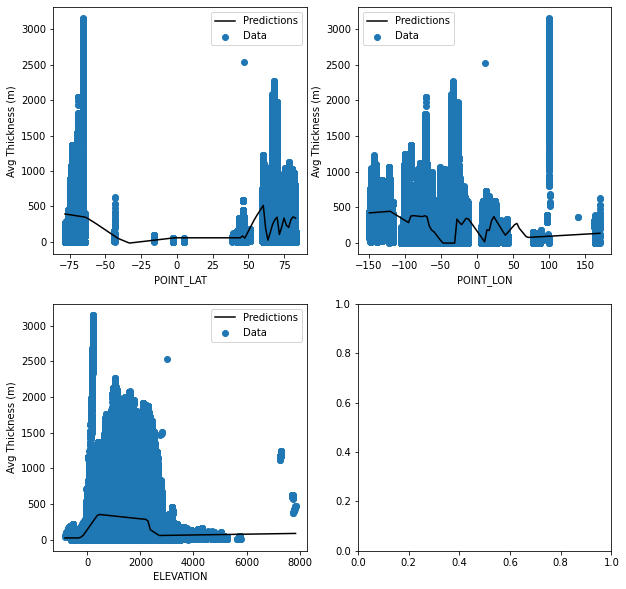

In [26]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    xmax = np.max(train_features[variable_name])
    xmin = np.min(train_features[variable_name])
    x = tf.linspace(xmin, xmax, 101)
    y = dnn_model[variable_name].predict(x)
    plot_single_model_variable(x,y,variable_name)

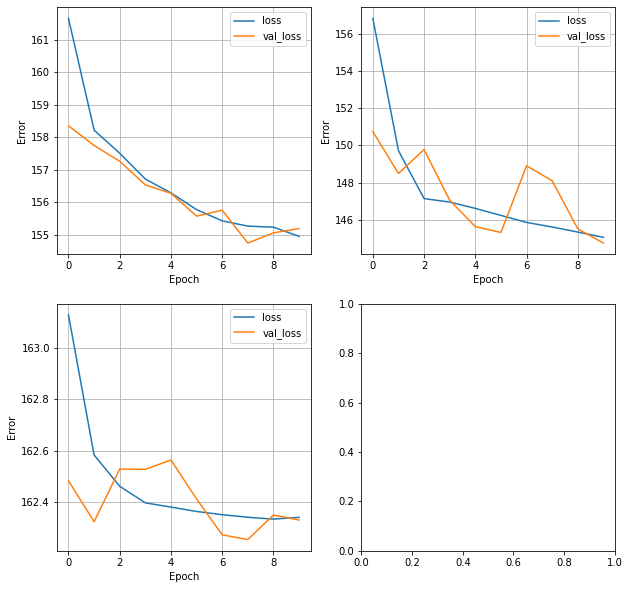

In [27]:
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    plt.subplot(2,2,i+1)
    plot_loss(dnn_history[variable_name])

In [28]:
dnn_full_model = build_dnn_model(normalizer['ALL'])

In [29]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, 
    epochs=10)

CPU times: user 1h 29min 33s, sys: 24min 7s, total: 1h 53min 41s
Wall time: 8min 54s


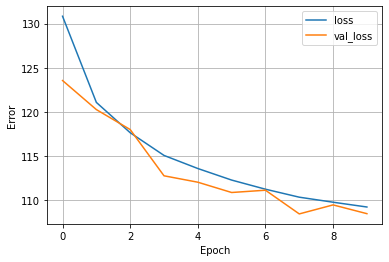

In [30]:
plot_loss(history_full)

Text(0, 0.5, 'Model Area (km**2)')

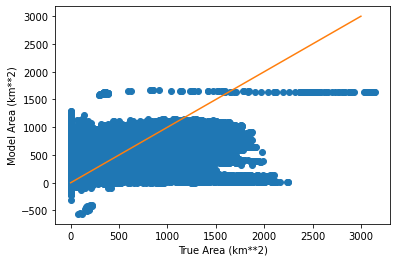

In [31]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'o')
plt.plot((0,3000),(0,3000),'-')
plt.xlabel('True Area (km**2)')
plt.ylabel('Model Area (km**2)')

<ipython-input-32-518d12a79147>:3: RuntimeWarning: divide by zero encountered in true_divide
  pct_error = (x-y)/x


ValueError: supplied range of [-inf, inf] is not finite

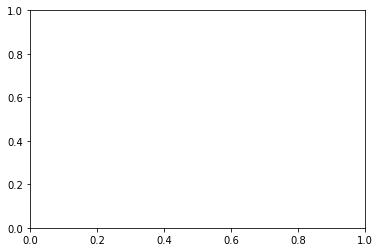

In [32]:
plt.subplots()
x = np.reshape(test_labels.values, (-1, 1)) # Training values in a n-by-1 array
pct_error = (x-y)/x
plt.hist(pct_error.flatten())
plt.xlabel('Percent Error')
plt.ylabel('Count')

In [ ]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results